# Задача 6. Компьютерное зрение: задача сегментации

* **Дедлайн**: 11.04.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


-  Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
-  Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
-  Попробовать улучшить качество изменяя архитектуру.
-  (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
-  (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

## Импорты

In [1]:
import numpy as np
import torch
import torchvision.transforms as tr
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models


from torch.utils.data import Dataset
from torchvision import io
from torch import nn
from glob import glob
from tqdm.auto import tqdm

C:\Users\Aorus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

## Константы, сиды и их фиксация

In [4]:
SEED = 1337
SPLIT_RATIO = 0.85

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Датасет

Был взят предложенный в задании датасет и скачан локально

### SelfieDataset

Был взят класс SelfieDataset из примера и немного изменен. Класс наследуется от класса Dataset из torch.utils.data.

In [5]:
class SelfieDataset(Dataset):
    def __init__(self, images, masks, transform=tr.Compose([
        tr.ToPILImage(),
        tr.Resize((800, 600)),
        tr.ToTensor(),
    ])):
        self.transform = transform
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        mask = self.transform(io.read_image(self.masks[item]) / 255)
        img = self.transform(io.read_image(self.images[item]) / 255)
        return img, mask

## Считывание и разбиение датасета

In [6]:
images_list = glob("./dataset/images/*.jpg")
masks_list = glob("./dataset/masks/*.png")

split_index = int(len(images_list) * SPLIT_RATIO)

train_dataset = SelfieDataset(images_list[:split_index], masks_list[:split_index])
test_dataset = SelfieDataset(images_list[split_index:], masks_list[split_index:])

## Классы U-Net архитектуры

Взяты из примера

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()
        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq_block(x)

In [8]:
class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
        super(CNNBlocks, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.extend([
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                nn.MaxPool2d(2, 2)
            ])
            in_channels = out_channels
            out_channels *= 2

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks):
                connections.append(x)

        return x, connections

In [10]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()
        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for _ in range(n_up):
            self.layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)
            ])
            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)

            x = layer(x)
        return x

In [11]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Обучение

In [12]:
device = torch.device("cuda:0")
criterion = nn.BCEWithLogitsLoss()

Функция `train_and_validate` обучает модель сегментации UNet на тренировочном датасете, периодически валидируя её на отложенной выборке. В процессе она вычисляет и сохраняет значения функции потерь и метрики Jaccard Index для обеих выборок, а после завершения обучения строит графики с динамикой этих показателей по эпохам. В конце функция возвращает обученную модель.

In [13]:
def jaccard_index(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets - preds * targets).sum(dim=(1, 2, 3))
    return (intersection / (union + 1e-8)).mean().item()


def train_and_validate(model, train_dataset, val_dataset, criterion, device,
                       epochs=10, batch_size=4, lr=1e-3, val_every=1, metrics_summary: dict = None, label: str = None):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_jaccards = []
    val_jaccards = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        total_train_jaccard = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_jaccard += jaccard_index(outputs.detach().cpu(), masks.cpu())

        train_loss = total_train_loss / len(train_loader)
        train_jaccard = total_train_jaccard / len(train_loader)

        train_losses.append(train_loss)
        train_jaccards.append(train_jaccard)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Jaccard: {train_jaccard:.4f}")

        if epoch % val_every == 0:
            model.eval()
            total_val_loss = 0
            total_val_jaccard = 0
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Validation"):
                    images = images.to(device)
                    masks = masks.to(device)
                    outputs = model(images)

                    loss = criterion(outputs, masks)
                    total_val_loss += loss.item()
                    total_val_jaccard += jaccard_index(outputs.cpu(), masks.cpu())

            val_loss = total_val_loss / len(val_loader)
            val_jaccard = total_val_jaccard / len(val_loader)
            val_losses.append(val_loss)
            val_jaccards.append(val_jaccard)

            print(f"[Epoch {epoch}] Val Loss: {val_loss:.4f} | Val Jaccard: {val_jaccard:.4f}")

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range[::val_every], val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_jaccards, label='Train Jaccard')
    plt.plot(epochs_range[::val_every], val_jaccards, label='Val Jaccard')
    plt.title('Jaccard Index over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Jaccard Index')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if metrics_summary is not None and label is not None:
        metrics_summary[label] = {
            "Train Loss": train_losses[-1],
            "Val Loss": val_losses[-1],
            "Train Jaccard": train_jaccards[-1],
            "Val Jaccard": val_jaccards[-1],
        }

    return model


#### 1. Переобучение

Epoch 1/40 - Training: 100%|██████████| 425/425 [01:27<00:00,  4.83it/s]


[Epoch 1] Train Loss: 0.5525 | Train Jaccard: 0.5718


Epoch 1/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.89it/s]


[Epoch 1] Val Loss: 0.5096 | Val Jaccard: 0.6155


Epoch 2/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 2] Train Loss: 0.4407 | Train Jaccard: 0.6794


Epoch 2/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.36it/s]


[Epoch 2] Val Loss: 0.4430 | Val Jaccard: 0.6891


Epoch 3/40 - Training: 100%|██████████| 425/425 [01:35<00:00,  4.46it/s]


[Epoch 3] Train Loss: 0.3880 | Train Jaccard: 0.7216


Epoch 3/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.23it/s]


[Epoch 3] Val Loss: 0.3823 | Val Jaccard: 0.7256


Epoch 4/40 - Training: 100%|██████████| 425/425 [01:35<00:00,  4.43it/s]


[Epoch 4] Train Loss: 0.3537 | Train Jaccard: 0.7486


Epoch 4/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.21it/s]


[Epoch 4] Val Loss: 0.3648 | Val Jaccard: 0.7034


Epoch 5/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.40it/s]


[Epoch 5] Train Loss: 0.3192 | Train Jaccard: 0.7725


Epoch 5/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.03it/s]


[Epoch 5] Val Loss: 0.3387 | Val Jaccard: 0.7635


Epoch 6/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.42it/s]


[Epoch 6] Train Loss: 0.2942 | Train Jaccard: 0.7928


Epoch 6/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.12it/s]


[Epoch 6] Val Loss: 0.2941 | Val Jaccard: 0.7871


Epoch 7/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.39it/s]


[Epoch 7] Train Loss: 0.2722 | Train Jaccard: 0.8064


Epoch 7/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s]


[Epoch 7] Val Loss: 0.2970 | Val Jaccard: 0.7862


Epoch 8/40 - Training: 100%|██████████| 425/425 [01:34<00:00,  4.48it/s]


[Epoch 8] Train Loss: 0.2511 | Train Jaccard: 0.8235


Epoch 8/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.66it/s]


[Epoch 8] Val Loss: 0.2585 | Val Jaccard: 0.8167


Epoch 9/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.56it/s]


[Epoch 9] Train Loss: 0.2349 | Train Jaccard: 0.8347


Epoch 9/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.89it/s]


[Epoch 9] Val Loss: 0.2564 | Val Jaccard: 0.8133


Epoch 10/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 10] Train Loss: 0.2247 | Train Jaccard: 0.8434


Epoch 10/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.87it/s]


[Epoch 10] Val Loss: 0.2321 | Val Jaccard: 0.8299


Epoch 11/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.56it/s]


[Epoch 11] Train Loss: 0.2087 | Train Jaccard: 0.8539


Epoch 11/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.67it/s]


[Epoch 11] Val Loss: 0.2258 | Val Jaccard: 0.8348


Epoch 12/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 12] Train Loss: 0.1962 | Train Jaccard: 0.8628


Epoch 12/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.86it/s]


[Epoch 12] Val Loss: 0.2091 | Val Jaccard: 0.8487


Epoch 13/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 13] Train Loss: 0.1873 | Train Jaccard: 0.8687


Epoch 13/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.83it/s]


[Epoch 13] Val Loss: 0.2028 | Val Jaccard: 0.8511


Epoch 14/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 14] Train Loss: 0.1798 | Train Jaccard: 0.8753


Epoch 14/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.73it/s]


[Epoch 14] Val Loss: 0.1971 | Val Jaccard: 0.8599


Epoch 15/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.56it/s]


[Epoch 15] Train Loss: 0.1697 | Train Jaccard: 0.8813


Epoch 15/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.87it/s]


[Epoch 15] Val Loss: 0.1747 | Val Jaccard: 0.8680


Epoch 16/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 16] Train Loss: 0.1630 | Train Jaccard: 0.8851


Epoch 16/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.84it/s]


[Epoch 16] Val Loss: 0.1904 | Val Jaccard: 0.8601


Epoch 17/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 17] Train Loss: 0.1545 | Train Jaccard: 0.8919


Epoch 17/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.68it/s]


[Epoch 17] Val Loss: 0.1666 | Val Jaccard: 0.8755


Epoch 18/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 18] Train Loss: 0.1477 | Train Jaccard: 0.8964


Epoch 18/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.89it/s]


[Epoch 18] Val Loss: 0.1710 | Val Jaccard: 0.8719


Epoch 19/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 19] Train Loss: 0.1407 | Train Jaccard: 0.9011


Epoch 19/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.77it/s]


[Epoch 19] Val Loss: 0.1669 | Val Jaccard: 0.8833


Epoch 20/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.55it/s]


[Epoch 20] Train Loss: 0.1362 | Train Jaccard: 0.9038


Epoch 20/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.91it/s]


[Epoch 20] Val Loss: 0.1576 | Val Jaccard: 0.8835


Epoch 21/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 21] Train Loss: 0.1283 | Train Jaccard: 0.9092


Epoch 21/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.90it/s]


[Epoch 21] Val Loss: 0.1658 | Val Jaccard: 0.8818


Epoch 22/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 22] Train Loss: 0.1238 | Train Jaccard: 0.9127


Epoch 22/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.71it/s]


[Epoch 22] Val Loss: 0.1566 | Val Jaccard: 0.8851


Epoch 23/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.40it/s]


[Epoch 23] Train Loss: 0.1217 | Train Jaccard: 0.9145


Epoch 23/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.09it/s]


[Epoch 23] Val Loss: 0.1819 | Val Jaccard: 0.8702


Epoch 24/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.38it/s]


[Epoch 24] Train Loss: 0.1139 | Train Jaccard: 0.9188


Epoch 24/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.21it/s]


[Epoch 24] Val Loss: 0.1523 | Val Jaccard: 0.8876


Epoch 25/40 - Training: 100%|██████████| 425/425 [01:36<00:00,  4.40it/s]


[Epoch 25] Train Loss: 0.1091 | Train Jaccard: 0.9224


Epoch 25/40 - Validation: 100%|██████████| 75/75 [00:09<00:00,  8.08it/s]


[Epoch 25] Val Loss: 0.1714 | Val Jaccard: 0.8838


Epoch 26/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 26] Train Loss: 0.1047 | Train Jaccard: 0.9256


Epoch 26/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.81it/s]


[Epoch 26] Val Loss: 0.1546 | Val Jaccard: 0.8935


Epoch 27/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 27] Train Loss: 0.1031 | Train Jaccard: 0.9265


Epoch 27/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.82it/s]


[Epoch 27] Val Loss: 0.1583 | Val Jaccard: 0.8883


Epoch 28/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 28] Train Loss: 0.0980 | Train Jaccard: 0.9302


Epoch 28/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.55it/s]


[Epoch 28] Val Loss: 0.1605 | Val Jaccard: 0.8925


Epoch 29/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 29] Train Loss: 0.0913 | Train Jaccard: 0.9342


Epoch 29/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.67it/s]


[Epoch 29] Val Loss: 0.1493 | Val Jaccard: 0.8960


Epoch 30/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 30] Train Loss: 0.0898 | Train Jaccard: 0.9357


Epoch 30/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s]


[Epoch 30] Val Loss: 0.1636 | Val Jaccard: 0.8869


Epoch 31/40 - Training: 100%|██████████| 425/425 [01:34<00:00,  4.52it/s]


[Epoch 31] Train Loss: 0.0851 | Train Jaccard: 0.9394


Epoch 31/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.75it/s]


[Epoch 31] Val Loss: 0.1523 | Val Jaccard: 0.8941


Epoch 32/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 32] Train Loss: 0.0791 | Train Jaccard: 0.9432


Epoch 32/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.71it/s]


[Epoch 32] Val Loss: 0.1441 | Val Jaccard: 0.9007


Epoch 33/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 33] Train Loss: 0.0771 | Train Jaccard: 0.9446


Epoch 33/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.74it/s]


[Epoch 33] Val Loss: 0.1483 | Val Jaccard: 0.8982


Epoch 34/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 34] Train Loss: 0.0713 | Train Jaccard: 0.9484


Epoch 34/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.73it/s]


[Epoch 34] Val Loss: 0.1515 | Val Jaccard: 0.8969


Epoch 35/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 35] Train Loss: 0.0714 | Train Jaccard: 0.9484


Epoch 35/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.64it/s]


[Epoch 35] Val Loss: 0.1480 | Val Jaccard: 0.8940


Epoch 36/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.54it/s]


[Epoch 36] Train Loss: 0.0652 | Train Jaccard: 0.9529


Epoch 36/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.66it/s]


[Epoch 36] Val Loss: 0.1593 | Val Jaccard: 0.8948


Epoch 37/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 37] Train Loss: 0.0637 | Train Jaccard: 0.9537


Epoch 37/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.98it/s]


[Epoch 37] Val Loss: 0.1725 | Val Jaccard: 0.8872


Epoch 38/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.52it/s]


[Epoch 38] Train Loss: 0.0594 | Train Jaccard: 0.9568


Epoch 38/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.76it/s]


[Epoch 38] Val Loss: 0.1533 | Val Jaccard: 0.8990


Epoch 39/40 - Training: 100%|██████████| 425/425 [01:33<00:00,  4.53it/s]


[Epoch 39] Train Loss: 0.0550 | Train Jaccard: 0.9605


Epoch 39/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.84it/s]


[Epoch 39] Val Loss: 0.1715 | Val Jaccard: 0.8966


Epoch 40/40 - Training: 100%|██████████| 425/425 [01:34<00:00,  4.52it/s]


[Epoch 40] Train Loss: 0.0525 | Train Jaccard: 0.9620


Epoch 40/40 - Validation: 100%|██████████| 75/75 [00:08<00:00,  8.81it/s]


[Epoch 40] Val Loss: 0.1595 | Val Jaccard: 0.8949


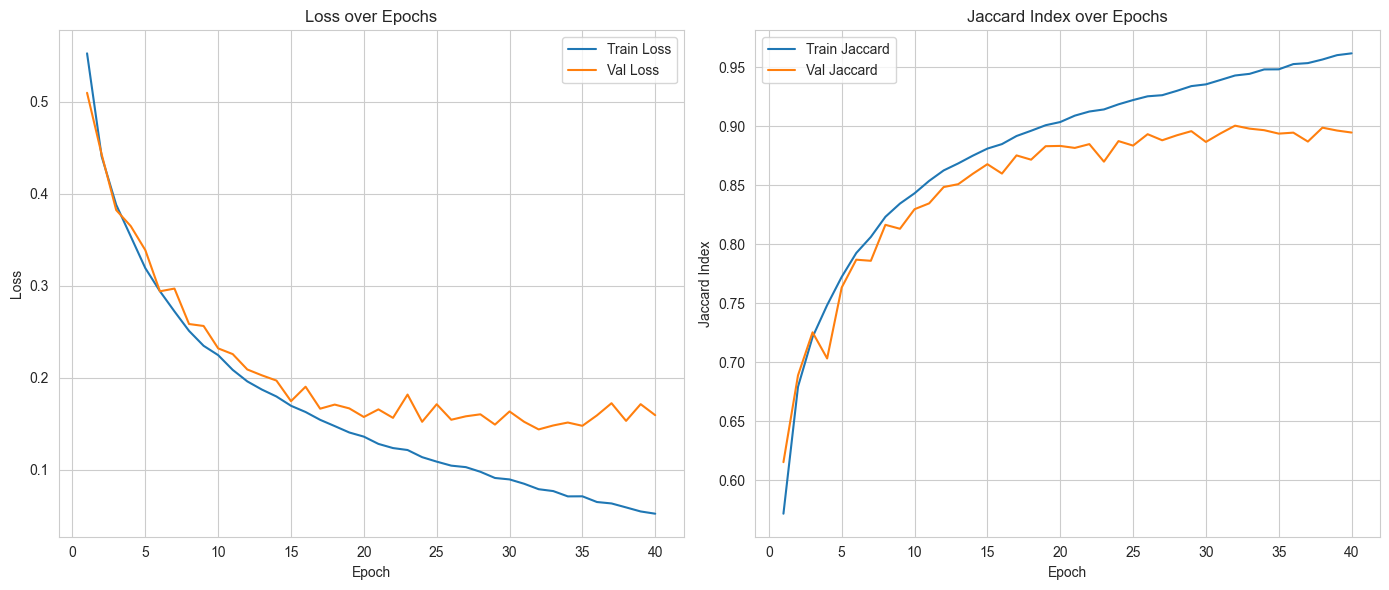

In [14]:
metrics = dict()
model = UNET(3, 16, 1)
trained_model = train_and_validate(model, train_dataset, test_dataset, criterion, device=device, epochs=40,
                                       batch_size=4, metrics_summary=metrics, label="overfitting")

Видно, около 15 эпох наилучшие результаты, а дальше они какое-то время не улучшаются, а потом вовсе уменьшается индекс и увеличиваются потери. Возьмем 15 эпох за основу в дальнейшем обучение, а batch size увеличим до 8

Посмотрим пару изображений и предсказанные маски

In [15]:
def get_predictions(model, dataset, device, indices=None, threshold=0.5):
    model.eval()
    model.to(device)

    if indices is None:
        indices = np.random.choice(len(dataset), 3, replace=False)

    triplets = []

    for idx in indices:
        image, mask = dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_batch)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        pred_mask = (pred > threshold).astype(np.float32)
        img_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask = mask.squeeze().cpu().numpy()

        triplets.append((img_np, pred_mask, true_mask))

    return triplets


def plot_prediction_triplets(triplets, titles=("Image", "Prediction", "Ground Truth")):
    num_examples = len(triplets)
    plt.figure(figsize=(12, 4 * num_examples))

    for i, (img, pred, gt) in enumerate(triplets):
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title(titles[0])
        plt.axis("off")

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(pred, cmap="gray")
        plt.title(titles[1])
        plt.axis("off")

        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(gt, cmap="gray")
        plt.title(titles[2])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


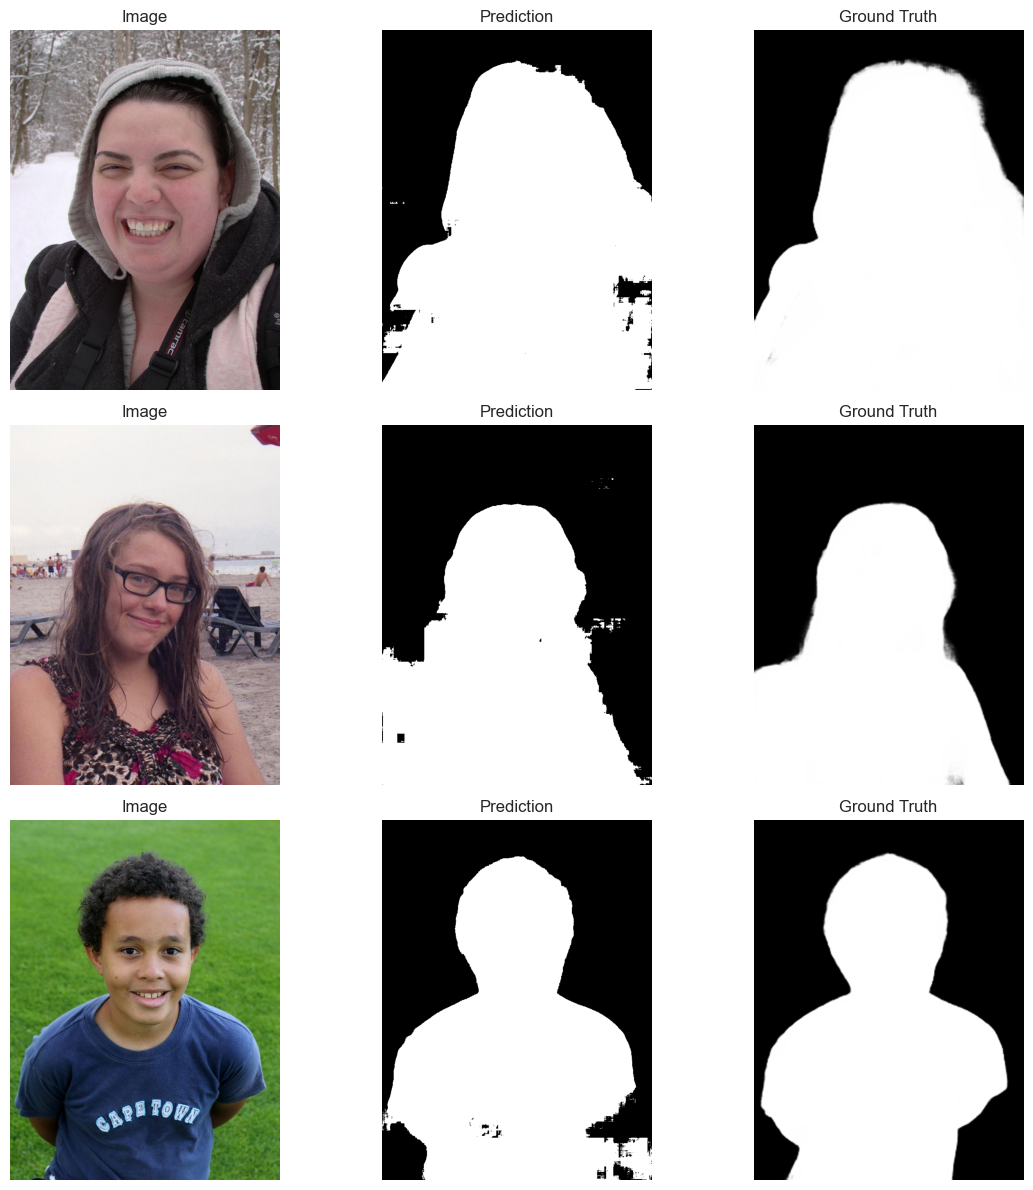

In [16]:
random_preds = get_predictions(trained_model, test_dataset, device=device)
plot_prediction_triplets(random_preds)

#### 2. Полное обучение

Epoch 1/15 - Training: 100%|██████████| 213/213 [02:46<00:00,  1.28it/s]


[Epoch 1] Train Loss: 0.5431 | Train Jaccard: 0.6079


Epoch 1/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.37it/s]


[Epoch 1] Val Loss: 0.4600 | Val Jaccard: 0.6391


Epoch 2/15 - Training: 100%|██████████| 213/213 [02:44<00:00,  1.30it/s]


[Epoch 2] Train Loss: 0.4112 | Train Jaccard: 0.7084


Epoch 2/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


[Epoch 2] Val Loss: 0.4370 | Val Jaccard: 0.6818


Epoch 3/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 3] Train Loss: 0.3748 | Train Jaccard: 0.7322


Epoch 3/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]


[Epoch 3] Val Loss: 0.3461 | Val Jaccard: 0.7563


Epoch 4/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 4] Train Loss: 0.3202 | Train Jaccard: 0.7726


Epoch 4/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


[Epoch 4] Val Loss: 0.3658 | Val Jaccard: 0.7665


Epoch 5/15 - Training: 100%|██████████| 213/213 [02:42<00:00,  1.31it/s]


[Epoch 5] Train Loss: 0.2868 | Train Jaccard: 0.7991


Epoch 5/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


[Epoch 5] Val Loss: 0.2903 | Val Jaccard: 0.7799


Epoch 6/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 6] Train Loss: 0.2634 | Train Jaccard: 0.8170


Epoch 6/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


[Epoch 6] Val Loss: 0.2679 | Val Jaccard: 0.8107


Epoch 7/15 - Training: 100%|██████████| 213/213 [02:42<00:00,  1.31it/s]


[Epoch 7] Train Loss: 0.2455 | Train Jaccard: 0.8289


Epoch 7/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


[Epoch 7] Val Loss: 0.2475 | Val Jaccard: 0.8183


Epoch 8/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 8] Train Loss: 0.2292 | Train Jaccard: 0.8390


Epoch 8/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


[Epoch 8] Val Loss: 0.2378 | Val Jaccard: 0.8337


Epoch 9/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 9] Train Loss: 0.2131 | Train Jaccard: 0.8511


Epoch 9/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


[Epoch 9] Val Loss: 0.2116 | Val Jaccard: 0.8498


Epoch 10/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 10] Train Loss: 0.1957 | Train Jaccard: 0.8635


Epoch 10/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


[Epoch 10] Val Loss: 0.2059 | Val Jaccard: 0.8504


Epoch 11/15 - Training: 100%|██████████| 213/213 [02:44<00:00,  1.30it/s]


[Epoch 11] Train Loss: 0.1898 | Train Jaccard: 0.8678


Epoch 11/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.38it/s]


[Epoch 11] Val Loss: 0.2547 | Val Jaccard: 0.8411


Epoch 12/15 - Training: 100%|██████████| 213/213 [02:43<00:00,  1.30it/s]


[Epoch 12] Train Loss: 0.1749 | Train Jaccard: 0.8774


Epoch 12/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


[Epoch 12] Val Loss: 0.1943 | Val Jaccard: 0.8709


Epoch 13/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 13] Train Loss: 0.1646 | Train Jaccard: 0.8841


Epoch 13/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


[Epoch 13] Val Loss: 0.1682 | Val Jaccard: 0.8807


Epoch 14/15 - Training: 100%|██████████| 213/213 [02:41<00:00,  1.32it/s]


[Epoch 14] Train Loss: 0.1584 | Train Jaccard: 0.8890


Epoch 14/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


[Epoch 14] Val Loss: 0.2008 | Val Jaccard: 0.8641


Epoch 15/15 - Training: 100%|██████████| 213/213 [02:45<00:00,  1.29it/s]


[Epoch 15] Train Loss: 0.1512 | Train Jaccard: 0.8939


Epoch 15/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s]


[Epoch 15] Val Loss: 0.1731 | Val Jaccard: 0.8753


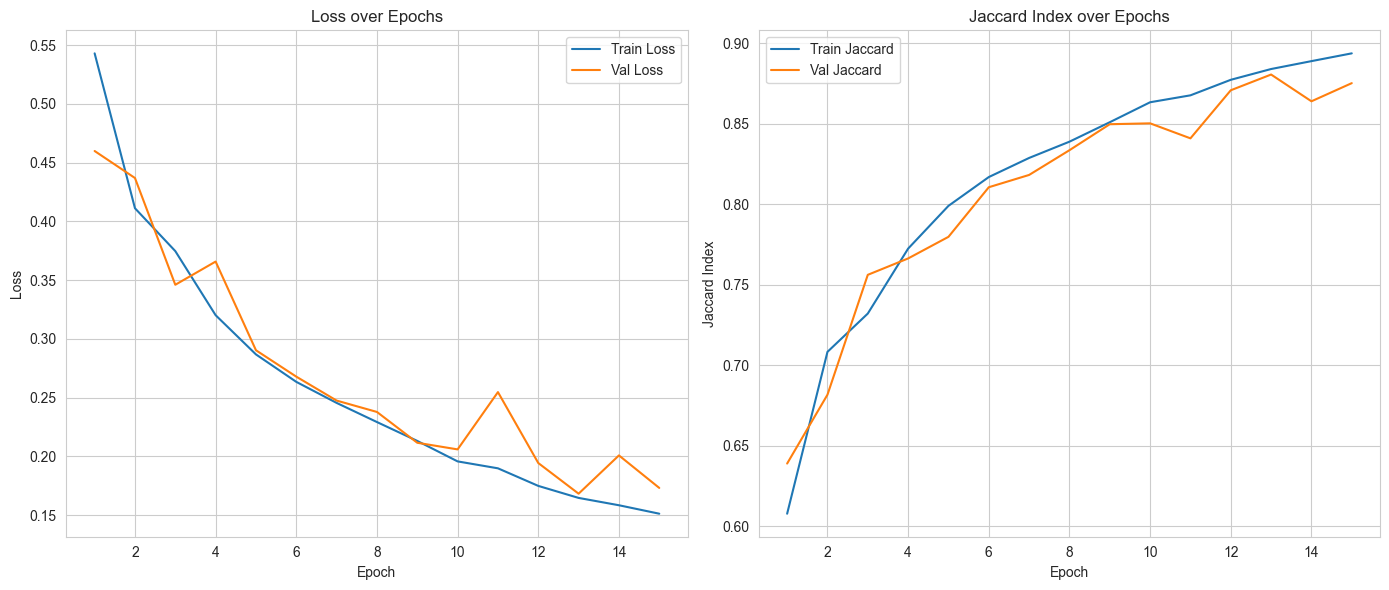

In [17]:
model = UNET(3, 16, 1)
trained_model = train_and_validate(model, train_dataset, test_dataset, criterion, device=device, epochs=15,
                                       batch_size=8, metrics_summary=metrics, label="fitting")

Как можно заметить графики имеют более выраженную тенденцию к улучшению результатов. Поссмотрим несколько фото

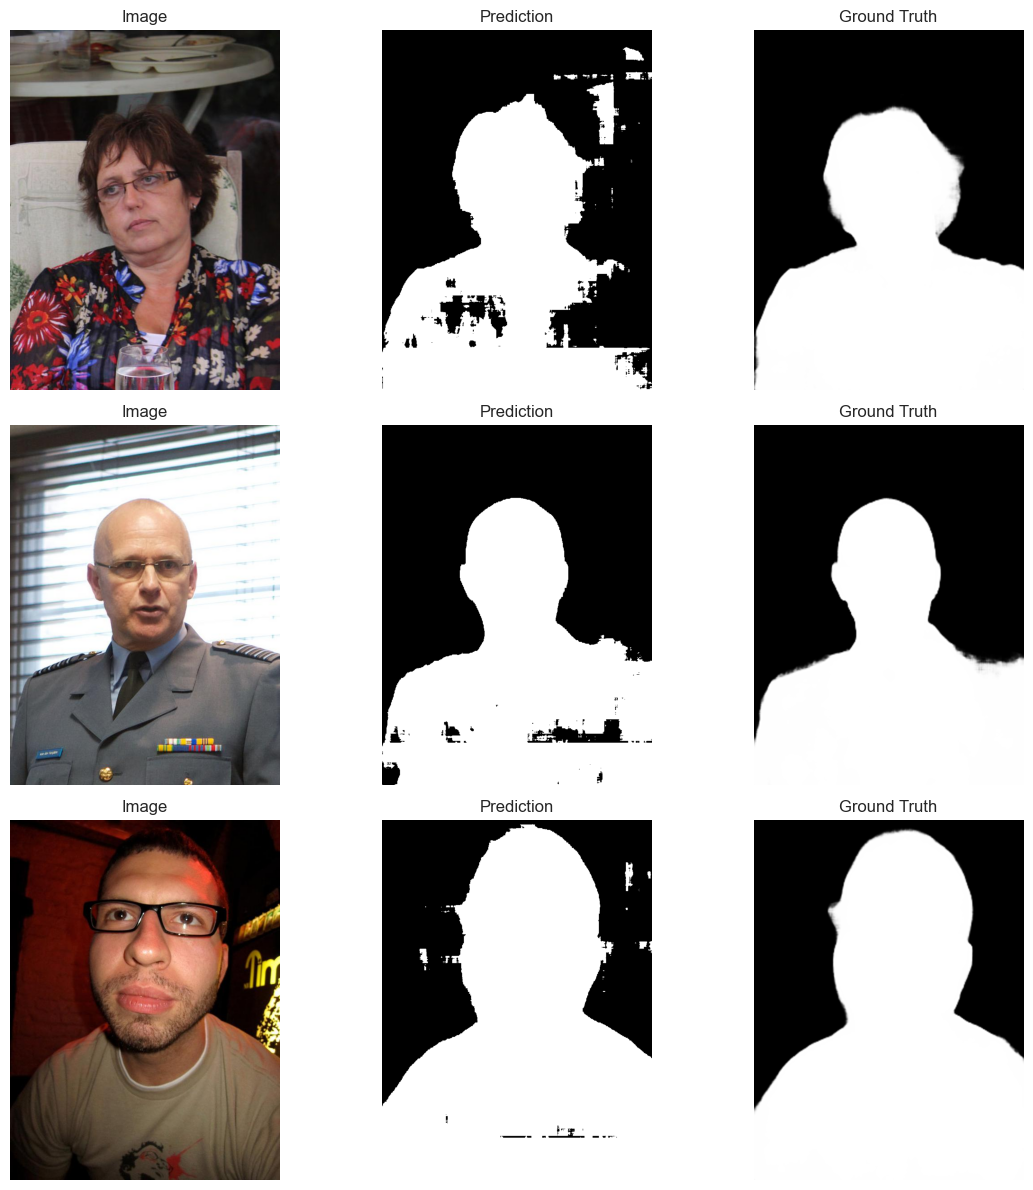

In [18]:
random_preds = get_predictions(trained_model, test_dataset, device=device)
plot_prediction_triplets(random_preds)

## TopN худших

Evaluating Jaccard: 100%|██████████| 300/300 [00:10<00:00, 28.94it/s]


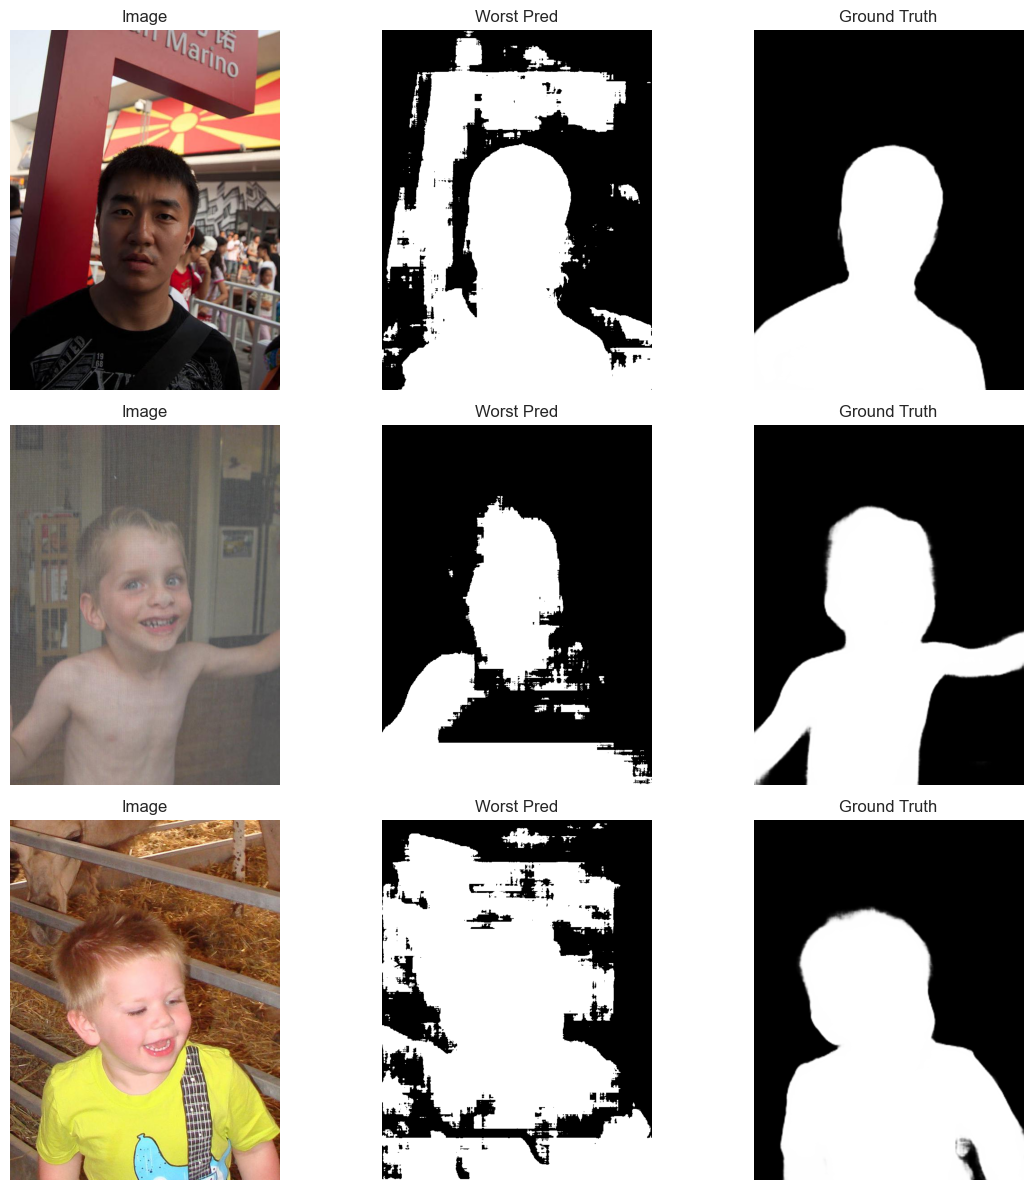

In [19]:
def topN_worst(model, dataset, device, top_n=5, threshold=0.5):
    model.eval()
    model.to(device)

    jaccard_scores = []

    for idx in tqdm(range(len(dataset)), desc="Evaluating Jaccard"):
        image, mask = dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_batch)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        pred_mask = (pred > threshold).astype(np.float32)
        true_mask = mask.squeeze().cpu().numpy()

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        jaccard = intersection / (union + 1e-8)
        jaccard_scores.append(jaccard)

    jaccard_scores = np.array(jaccard_scores)
    worst_indices = np.argsort(jaccard_scores)[:top_n].tolist()
    return worst_indices


worst_ids = topN_worst(trained_model, test_dataset, device=device, top_n=3)
triplets = get_predictions(trained_model, test_dataset, device=device, indices=worst_ids)
plot_prediction_triplets(triplets, titles=("Image", "Worst Pred", "Ground Truth"))


Фото с наибольшим количеством шумов и наиболее размытые обрабатываются хуже всего

## Аугментация

Разнообразим тренировочные данные с помощью аугментации

In [20]:
augmentation_transform = tr.Compose([
    tr.ToPILImage(),
    tr.Resize((800, 600)),
    tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tr.RandomHorizontalFlip(p=0.5),
    tr.RandomVerticalFlip(p=0.1),
    tr.ToTensor()
])

train_dataset_augmented = SelfieDataset(
    images=train_dataset.images,
    masks=train_dataset.masks,
    transform=augmentation_transform
)

train_dataset_extended = torch.utils.data.ConcatDataset([
    train_dataset,
    train_dataset_augmented
])


Пример преобразования

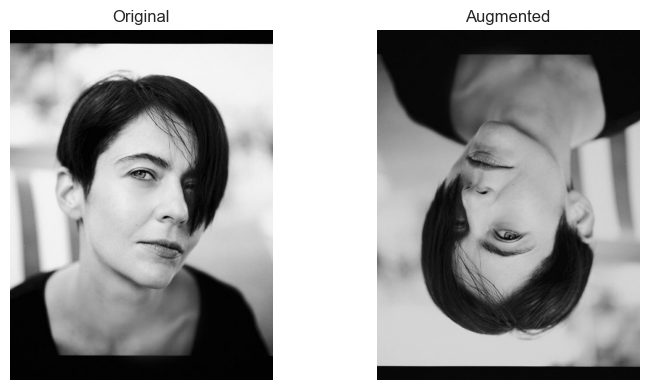

In [21]:
def show_images(first_img, second_img, titles):
    def to_numpy(t):
        if t.ndim == 3 and t.shape[0] == 3:
            return t.permute(1, 2, 0).cpu().numpy()
        elif t.ndim == 2:
            return t.cpu().numpy()
        else:
            raise ValueError("Unexpected tensor shape")

    first = to_numpy(first_img)
    second = to_numpy(second_img)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(first)
    plt.title(titles[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(second)
    plt.title(titles[1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()


random_idx = torch.randint(0, len(train_dataset), (1,)).item()

original_img, _ = train_dataset[random_idx]
augmented_img, _ = train_dataset_augmented[random_idx]

show_images(original_img, augmented_img, ['Original', 'Augmented'])


Epoch 1/15 - Training: 100%|██████████| 425/425 [06:08<00:00,  1.15it/s]


[Epoch 1] Train Loss: 0.5846 | Train Jaccard: 0.5488


Epoch 1/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.37it/s]


[Epoch 1] Val Loss: 0.5068 | Val Jaccard: 0.6501


Epoch 2/15 - Training: 100%|██████████| 425/425 [06:02<00:00,  1.17it/s]


[Epoch 2] Train Loss: 0.5069 | Train Jaccard: 0.6279


Epoch 2/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


[Epoch 2] Val Loss: 0.4081 | Val Jaccard: 0.7076


Epoch 3/15 - Training: 100%|██████████| 425/425 [06:01<00:00,  1.18it/s]


[Epoch 3] Train Loss: 0.4766 | Train Jaccard: 0.6589


Epoch 3/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


[Epoch 3] Val Loss: 0.4346 | Val Jaccard: 0.6243


Epoch 4/15 - Training: 100%|██████████| 425/425 [06:01<00:00,  1.18it/s]


[Epoch 4] Train Loss: 0.4593 | Train Jaccard: 0.6765


Epoch 4/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


[Epoch 4] Val Loss: 0.3484 | Val Jaccard: 0.7549


Epoch 5/15 - Training: 100%|██████████| 425/425 [06:03<00:00,  1.17it/s]


[Epoch 5] Train Loss: 0.4325 | Train Jaccard: 0.6975


Epoch 5/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.36it/s]


[Epoch 5] Val Loss: 0.3423 | Val Jaccard: 0.7517


Epoch 6/15 - Training: 100%|██████████| 425/425 [06:10<00:00,  1.15it/s]


[Epoch 6] Train Loss: 0.4196 | Train Jaccard: 0.7117


Epoch 6/15 - Validation: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


[Epoch 6] Val Loss: 0.3144 | Val Jaccard: 0.7849


Epoch 7/15 - Training: 100%|██████████| 425/425 [06:02<00:00,  1.17it/s]


[Epoch 7] Train Loss: 0.3950 | Train Jaccard: 0.7332


Epoch 7/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


[Epoch 7] Val Loss: 0.2763 | Val Jaccard: 0.8106


Epoch 8/15 - Training: 100%|██████████| 425/425 [06:05<00:00,  1.16it/s]


[Epoch 8] Train Loss: 0.3834 | Train Jaccard: 0.7449


Epoch 8/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


[Epoch 8] Val Loss: 0.2883 | Val Jaccard: 0.7935


Epoch 9/15 - Training: 100%|██████████| 425/425 [06:04<00:00,  1.17it/s]


[Epoch 9] Train Loss: 0.3781 | Train Jaccard: 0.7537


Epoch 9/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


[Epoch 9] Val Loss: 0.2630 | Val Jaccard: 0.8351


Epoch 10/15 - Training: 100%|██████████| 425/425 [06:01<00:00,  1.18it/s]


[Epoch 10] Train Loss: 0.3722 | Train Jaccard: 0.7595


Epoch 10/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


[Epoch 10] Val Loss: 0.2355 | Val Jaccard: 0.8511


Epoch 11/15 - Training: 100%|██████████| 425/425 [06:05<00:00,  1.16it/s]


[Epoch 11] Train Loss: 0.3636 | Train Jaccard: 0.7675


Epoch 11/15 - Validation: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


[Epoch 11] Val Loss: 0.2331 | Val Jaccard: 0.8464


Epoch 12/15 - Training: 100%|██████████| 425/425 [06:01<00:00,  1.18it/s]


[Epoch 12] Train Loss: 0.3509 | Train Jaccard: 0.7778


Epoch 12/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.45it/s]


[Epoch 12] Val Loss: 0.2255 | Val Jaccard: 0.8587


Epoch 13/15 - Training: 100%|██████████| 425/425 [06:08<00:00,  1.15it/s]


[Epoch 13] Train Loss: 0.3476 | Train Jaccard: 0.7820


Epoch 13/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.41it/s]


[Epoch 13] Val Loss: 0.2125 | Val Jaccard: 0.8655


Epoch 14/15 - Training: 100%|██████████| 425/425 [06:02<00:00,  1.17it/s]


[Epoch 14] Train Loss: 0.3499 | Train Jaccard: 0.7818


Epoch 14/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


[Epoch 14] Val Loss: 0.2129 | Val Jaccard: 0.8716


Epoch 15/15 - Training: 100%|██████████| 425/425 [06:07<00:00,  1.16it/s]


[Epoch 15] Train Loss: 0.3419 | Train Jaccard: 0.7884


Epoch 15/15 - Validation: 100%|██████████| 38/38 [00:08<00:00,  4.42it/s]


[Epoch 15] Val Loss: 0.2123 | Val Jaccard: 0.8663


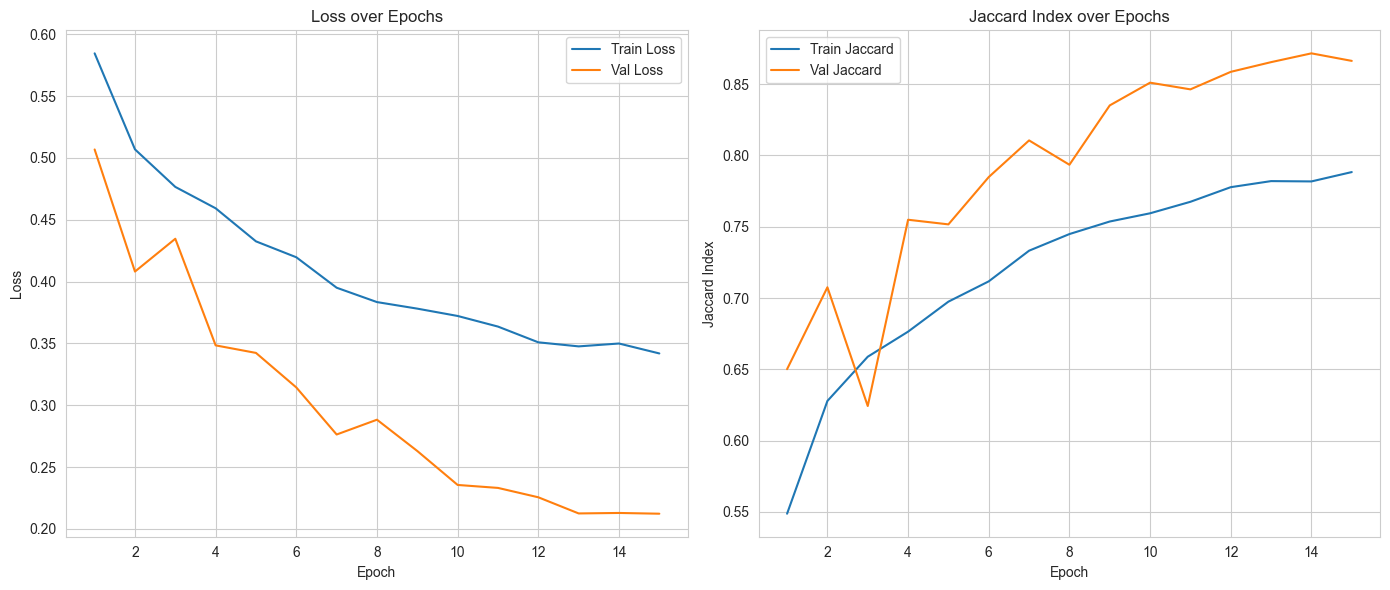

In [22]:
model = UNET(3, 16, 1)
trained_model = train_and_validate(model, train_dataset_extended, test_dataset, criterion, device=device, epochs=15,
                                       batch_size=8, metrics_summary=metrics, label="augmented")

Предварительно обработанные изображения показали себя гораздо хуже и нестабильней

In [23]:
def compare_metrics_table(metrics_summary):
    df = pd.DataFrame(metrics_summary).T
    styled_df = df.style \
        .format(precision=4) \
        .highlight_max(axis=0, color="lightgreen") \
        .highlight_min(axis=0, color="salmon")

    display(styled_df)
    return df

df_results = compare_metrics_table(metrics)

Пока что ovefitting себя показывает лучше всех, возможно стоило остановиться не на 15 эпохах, а на 20

## ResNet34

Теперь сделаем UNet с предобученным энкодером ResNet34

In [24]:
import torch.nn.functional as F

def center_crop_or_pad_to_match(source, target):
    """Приводит spatial размер source к размеру target (H, W)"""
    diff_y = target.size(2) - source.size(2)
    diff_x = target.size(3) - source.size(3)

    pad_left = diff_x // 2
    pad_right = diff_x - pad_left
    pad_top = diff_y // 2
    pad_bottom = diff_y - pad_top

    if diff_x != 0 or diff_y != 0:
        source = F.pad(source, [pad_left, pad_right, pad_top, pad_bottom])
    return source


class PretrainedUNet(nn.Module):
    def __init__(self, encoder_name='resnet34', pretrained=True, num_classes=1):
        super().__init__()

        resnet = getattr(models, encoder_name)(pretrained=pretrained)

        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # [B, 64, H/2, W/2]
        self.encoder1 = nn.Sequential(resnet.maxpool, resnet.layer1)          # [B, 64, H/4, W/4]
        self.encoder2 = resnet.layer2                                          # [B, 128, H/8, W/8]
        self.encoder3 = resnet.layer3                                          # [B, 256, H/16, W/16]
        self.encoder4 = resnet.layer4                                          # [B, 512, H/32, W/32]

        self.up4 = self._decoder_block(512, 256)
        self.up3 = self._decoder_block(256 + 256, 128)
        self.up2 = self._decoder_block(128 + 128, 64)
        self.up1 = self._decoder_block(64 + 64, 64)
        self.up0 = self._decoder_block(64 + 64, 32)

        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc0 = self.encoder0(x)
        enc1 = self.encoder1(enc0)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        dec4 = self.up4(enc4)
        dec3 = self.up3(torch.cat([center_crop_or_pad_to_match(dec4, enc3), enc3], dim=1))
        dec2 = self.up2(torch.cat([
            center_crop_or_pad_to_match(dec3, enc2),
            enc2
        ], dim=1))
        dec1 = self.up1(torch.cat([center_crop_or_pad_to_match(dec2, enc1), enc1], dim=1))
        dec0 = self.up0(torch.cat([center_crop_or_pad_to_match(dec1, enc0), enc0], dim=1))

        return self.final(dec0)


C:\Users\Aorus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aorus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15 - Training: 100%|██████████| 213/213 [19:02<00:00,  5.37s/it]


[Epoch 1] Train Loss: 0.1969 | Train Jaccard: 0.8572


Epoch 1/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 1] Val Loss: 0.1781 | Val Jaccard: 0.8632


Epoch 2/15 - Training: 100%|██████████| 213/213 [19:00<00:00,  5.36s/it]


[Epoch 2] Train Loss: 0.0951 | Train Jaccard: 0.9382


Epoch 2/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 2] Val Loss: 0.0893 | Val Jaccard: 0.9366


Epoch 3/15 - Training: 100%|██████████| 213/213 [18:58<00:00,  5.34s/it]


[Epoch 3] Train Loss: 0.0655 | Train Jaccard: 0.9565


Epoch 3/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 3] Val Loss: 0.0752 | Val Jaccard: 0.9491


Epoch 4/15 - Training: 100%|██████████| 213/213 [18:58<00:00,  5.34s/it]


[Epoch 4] Train Loss: 0.0527 | Train Jaccard: 0.9645


Epoch 4/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 4] Val Loss: 0.0671 | Val Jaccard: 0.9507


Epoch 5/15 - Training: 100%|██████████| 213/213 [18:58<00:00,  5.35s/it]


[Epoch 5] Train Loss: 0.0442 | Train Jaccard: 0.9691


Epoch 5/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 5] Val Loss: 0.0628 | Val Jaccard: 0.9557


Epoch 6/15 - Training: 100%|██████████| 213/213 [18:59<00:00,  5.35s/it]


[Epoch 6] Train Loss: 0.0502 | Train Jaccard: 0.9654


Epoch 6/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 6] Val Loss: 0.0587 | Val Jaccard: 0.9630


Epoch 7/15 - Training: 100%|██████████| 213/213 [18:59<00:00,  5.35s/it]


[Epoch 7] Train Loss: 0.0409 | Train Jaccard: 0.9718


Epoch 7/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 7] Val Loss: 0.0522 | Val Jaccard: 0.9623


Epoch 8/15 - Training: 100%|██████████| 213/213 [19:04<00:00,  5.37s/it]


[Epoch 8] Train Loss: 0.0378 | Train Jaccard: 0.9733


Epoch 8/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


[Epoch 8] Val Loss: 0.0588 | Val Jaccard: 0.9577


Epoch 9/15 - Training: 100%|██████████| 213/213 [18:54<00:00,  5.33s/it]


[Epoch 9] Train Loss: 0.0339 | Train Jaccard: 0.9759


Epoch 9/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.15it/s]


[Epoch 9] Val Loss: 0.0434 | Val Jaccard: 0.9694


Epoch 10/15 - Training: 100%|██████████| 213/213 [20:09<00:00,  5.68s/it]


[Epoch 10] Train Loss: 0.0391 | Train Jaccard: 0.9734


Epoch 10/15 - Validation: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s]


[Epoch 10] Val Loss: 0.0574 | Val Jaccard: 0.9586


Epoch 11/15 - Training: 100%|██████████| 213/213 [20:03<00:00,  5.65s/it]


[Epoch 11] Train Loss: 0.0320 | Train Jaccard: 0.9773


Epoch 11/15 - Validation: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]


[Epoch 11] Val Loss: 0.0501 | Val Jaccard: 0.9656


Epoch 12/15 - Training: 100%|██████████| 213/213 [20:10<00:00,  5.68s/it]


[Epoch 12] Train Loss: 0.0264 | Train Jaccard: 0.9811


Epoch 12/15 - Validation: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s]


[Epoch 12] Val Loss: 0.0379 | Val Jaccard: 0.9737


Epoch 13/15 - Training: 100%|██████████| 213/213 [20:12<00:00,  5.69s/it]


[Epoch 13] Train Loss: 0.0227 | Train Jaccard: 0.9836


Epoch 13/15 - Validation: 100%|██████████| 38/38 [00:36<00:00,  1.03it/s]


[Epoch 13] Val Loss: 0.0373 | Val Jaccard: 0.9734


Epoch 14/15 - Training: 100%|██████████| 213/213 [20:00<00:00,  5.64s/it]


[Epoch 14] Train Loss: 0.0220 | Train Jaccard: 0.9842


Epoch 14/15 - Validation: 100%|██████████| 38/38 [00:32<00:00,  1.15it/s]


[Epoch 14] Val Loss: 0.1043 | Val Jaccard: 0.9477


Epoch 15/15 - Training: 100%|██████████| 213/213 [20:28<00:00,  5.77s/it]


[Epoch 15] Train Loss: 0.0694 | Train Jaccard: 0.9536


Epoch 15/15 - Validation: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


[Epoch 15] Val Loss: 0.0615 | Val Jaccard: 0.9572


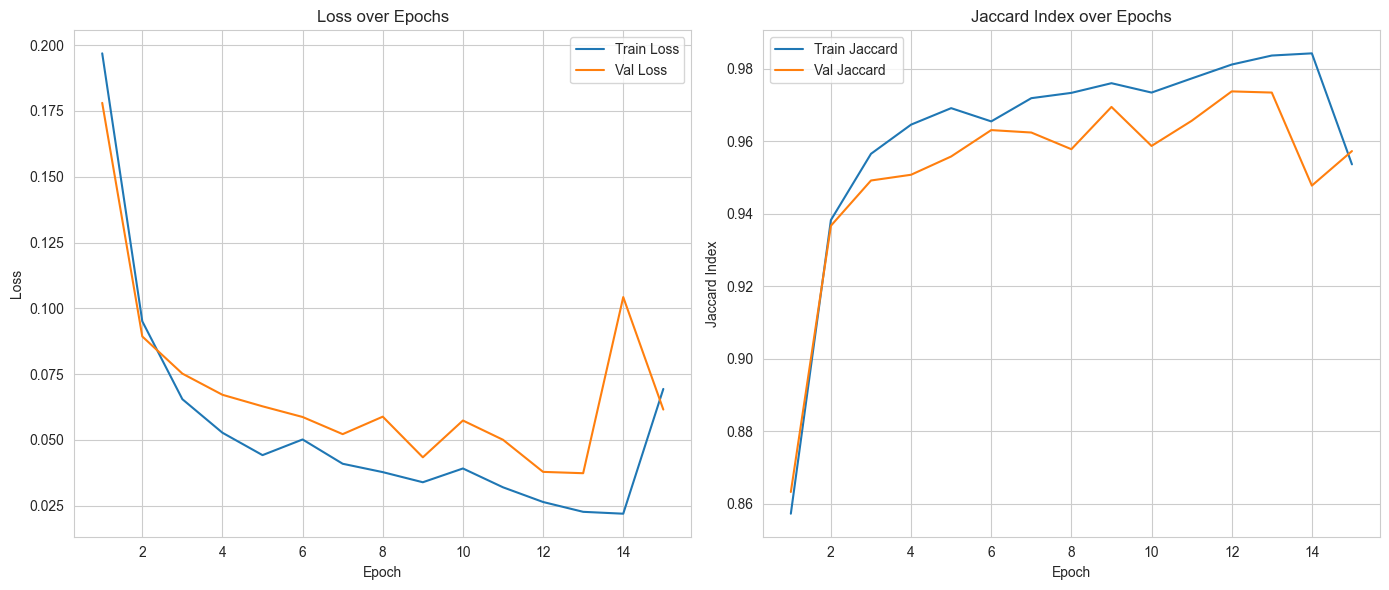

In [25]:
model = PretrainedUNet(encoder_name='resnet34', pretrained=True, num_classes=1)
trained_model = train_and_validate(model, train_dataset, test_dataset, criterion, device=device, epochs=15, metrics_summary=metrics, label="ResNet34", batch_size=8)

Потери и индекс кажутся очень неплохими на первый взгляд. Сделаем фолды и сравним все вместе

## 5Fold


====== Fold 1 ======



Epoch 1/3 - Training: 100%|██████████| 340/340 [03:28<00:00,  1.63it/s]


[Epoch 1] Train Loss: 0.5647 | Train Jaccard: 0.5600


Epoch 1/3 - Validation: 100%|██████████| 85/85 [00:12<00:00,  7.03it/s]


[Epoch 1] Val Loss: 0.7721 | Val Jaccard: 0.5950


Epoch 2/3 - Training: 100%|██████████| 340/340 [03:20<00:00,  1.69it/s]


[Epoch 2] Train Loss: 0.4822 | Train Jaccard: 0.6435


Epoch 2/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  9.18it/s]


[Epoch 2] Val Loss: 0.4265 | Val Jaccard: 0.7046


Epoch 3/3 - Training: 100%|██████████| 340/340 [03:21<00:00,  1.69it/s]


[Epoch 3] Train Loss: 0.4352 | Train Jaccard: 0.6868


Epoch 3/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s]


[Epoch 3] Val Loss: 0.4244 | Val Jaccard: 0.7047


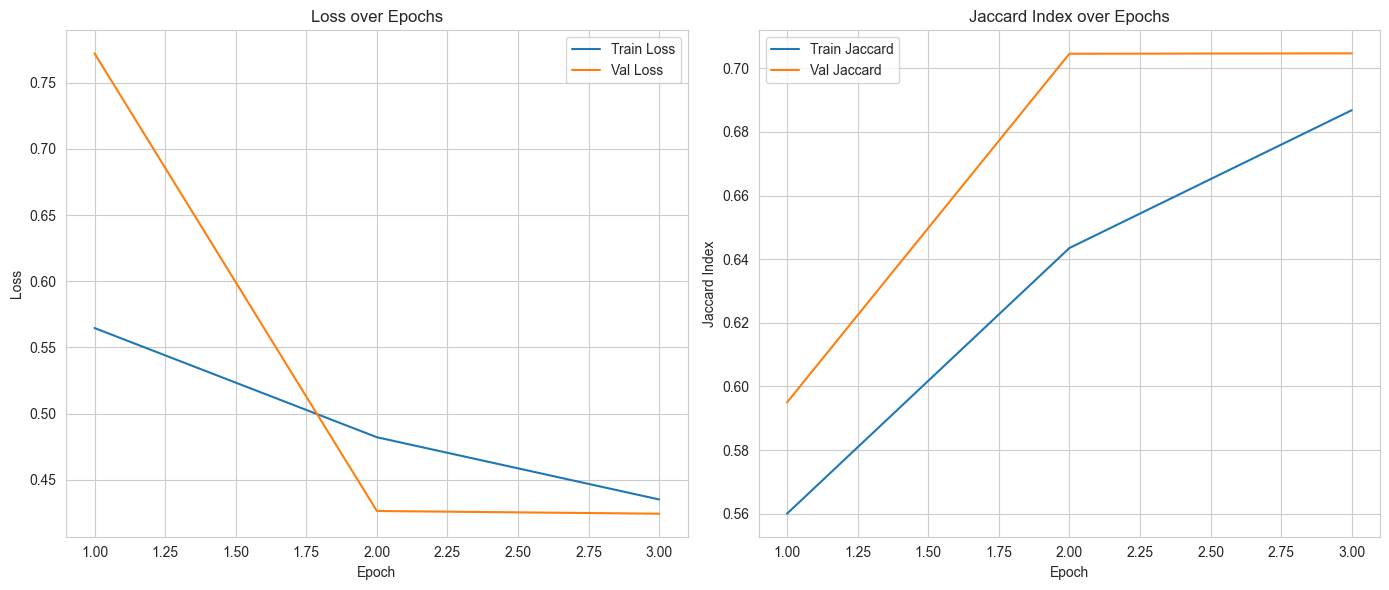

Evaluating Jaccard: 100%|██████████| 300/300 [00:09<00:00, 30.32it/s]


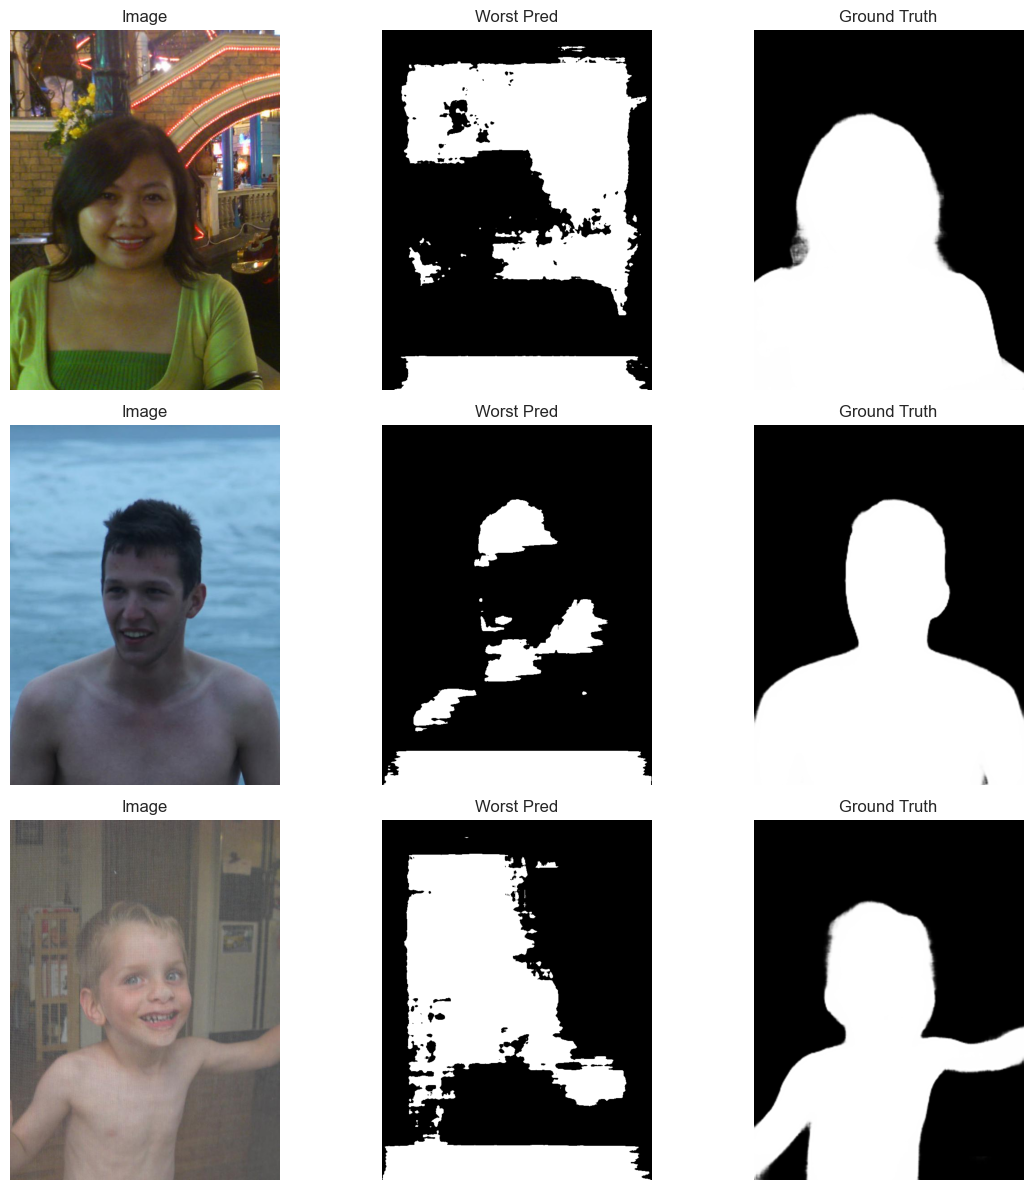


====== Fold 2 ======



Epoch 1/3 - Training: 100%|██████████| 340/340 [03:28<00:00,  1.63it/s]


[Epoch 1] Train Loss: 0.5704 | Train Jaccard: 0.5909


Epoch 1/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.26it/s]


[Epoch 1] Val Loss: 0.5110 | Val Jaccard: 0.5872


Epoch 2/3 - Training: 100%|██████████| 340/340 [03:26<00:00,  1.64it/s]


[Epoch 2] Train Loss: 0.4785 | Train Jaccard: 0.6606


Epoch 2/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.79it/s]


[Epoch 2] Val Loss: 0.4557 | Val Jaccard: 0.6439


Epoch 3/3 - Training: 100%|██████████| 340/340 [03:32<00:00,  1.60it/s]


[Epoch 3] Train Loss: 0.4131 | Train Jaccard: 0.7059


Epoch 3/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.56it/s]


[Epoch 3] Val Loss: 0.4673 | Val Jaccard: 0.6949


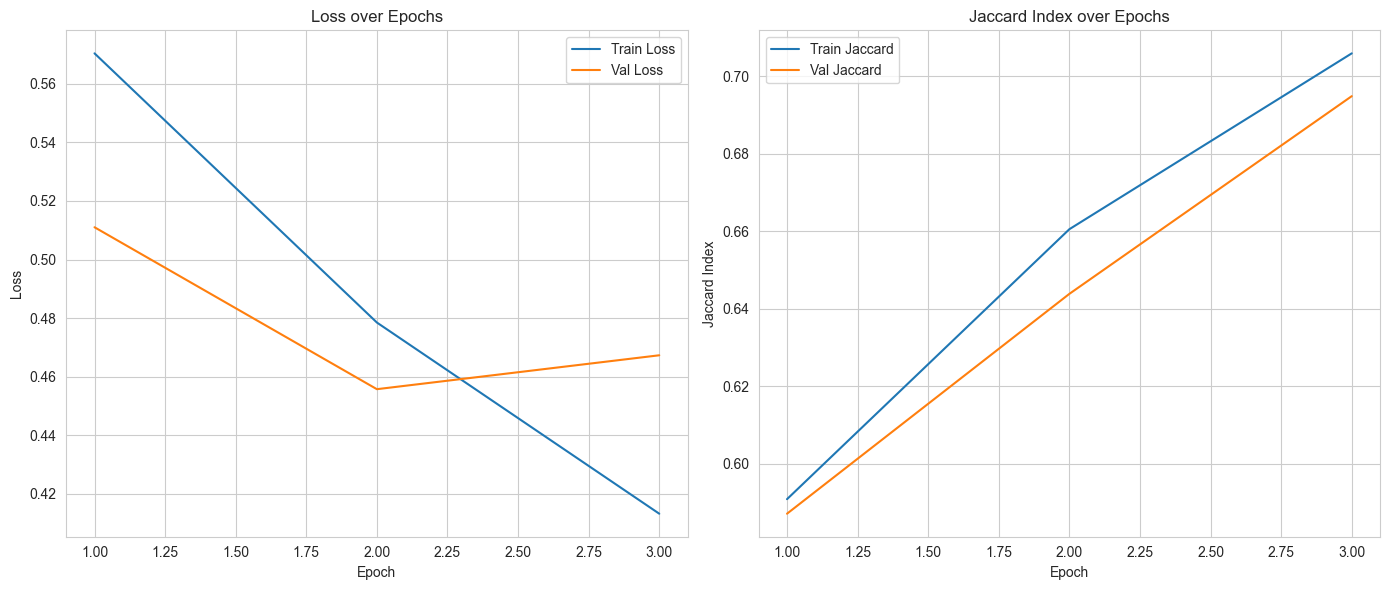

Evaluating Jaccard: 100%|██████████| 300/300 [00:11<00:00, 25.80it/s]


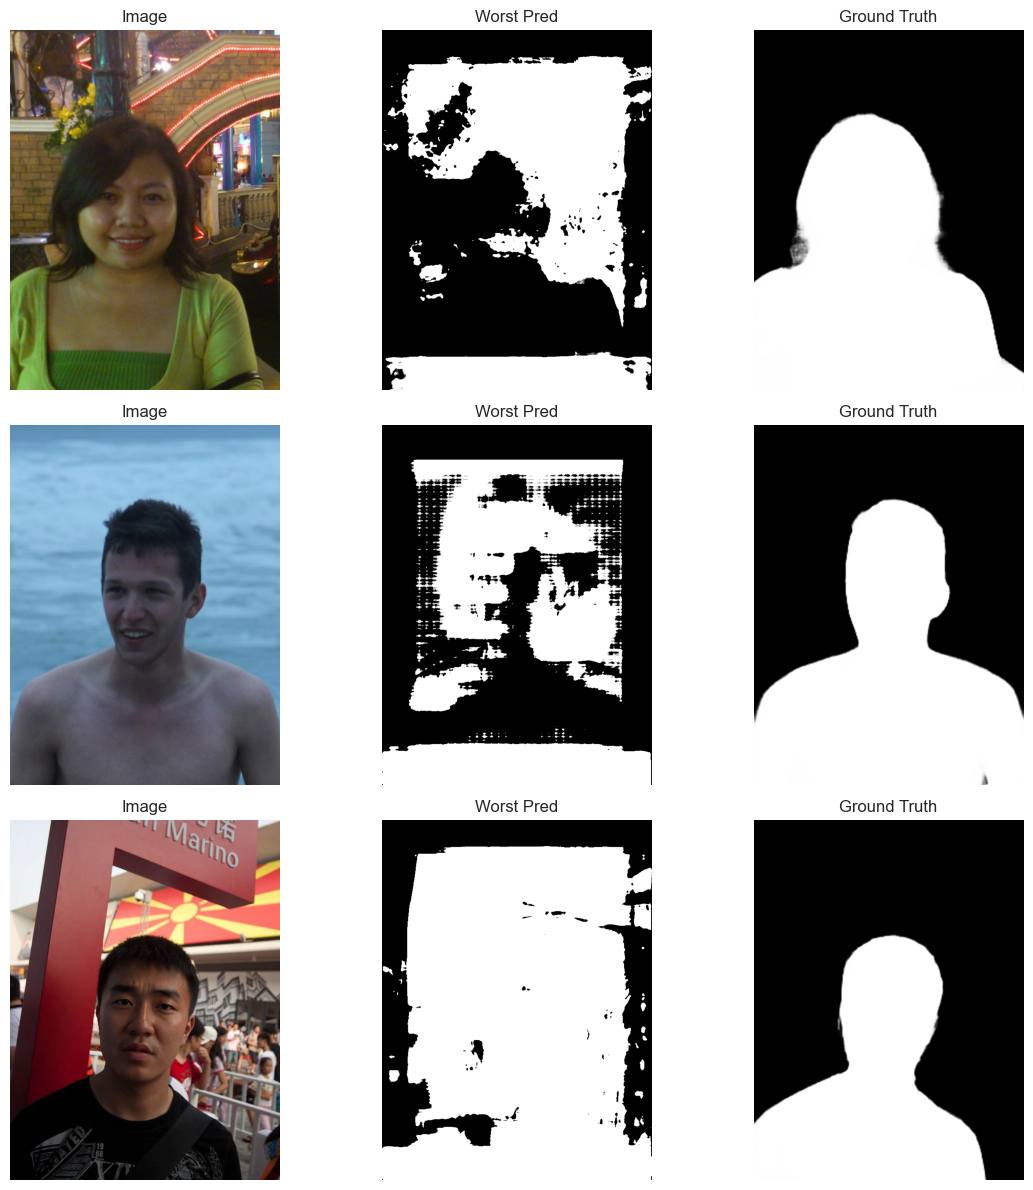


====== Fold 3 ======



Epoch 1/3 - Training: 100%|██████████| 340/340 [03:29<00:00,  1.62it/s]


[Epoch 1] Train Loss: 0.5581 | Train Jaccard: 0.5641


Epoch 1/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.60it/s]


[Epoch 1] Val Loss: 0.5108 | Val Jaccard: 0.6618


Epoch 2/3 - Training: 100%|██████████| 340/340 [03:31<00:00,  1.61it/s]


[Epoch 2] Train Loss: 0.4425 | Train Jaccard: 0.6820


Epoch 2/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.67it/s]


[Epoch 2] Val Loss: 0.4570 | Val Jaccard: 0.6821


Epoch 3/3 - Training: 100%|██████████| 340/340 [03:30<00:00,  1.62it/s]


[Epoch 3] Train Loss: 0.3947 | Train Jaccard: 0.7163


Epoch 3/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.68it/s]


[Epoch 3] Val Loss: 0.4105 | Val Jaccard: 0.7276


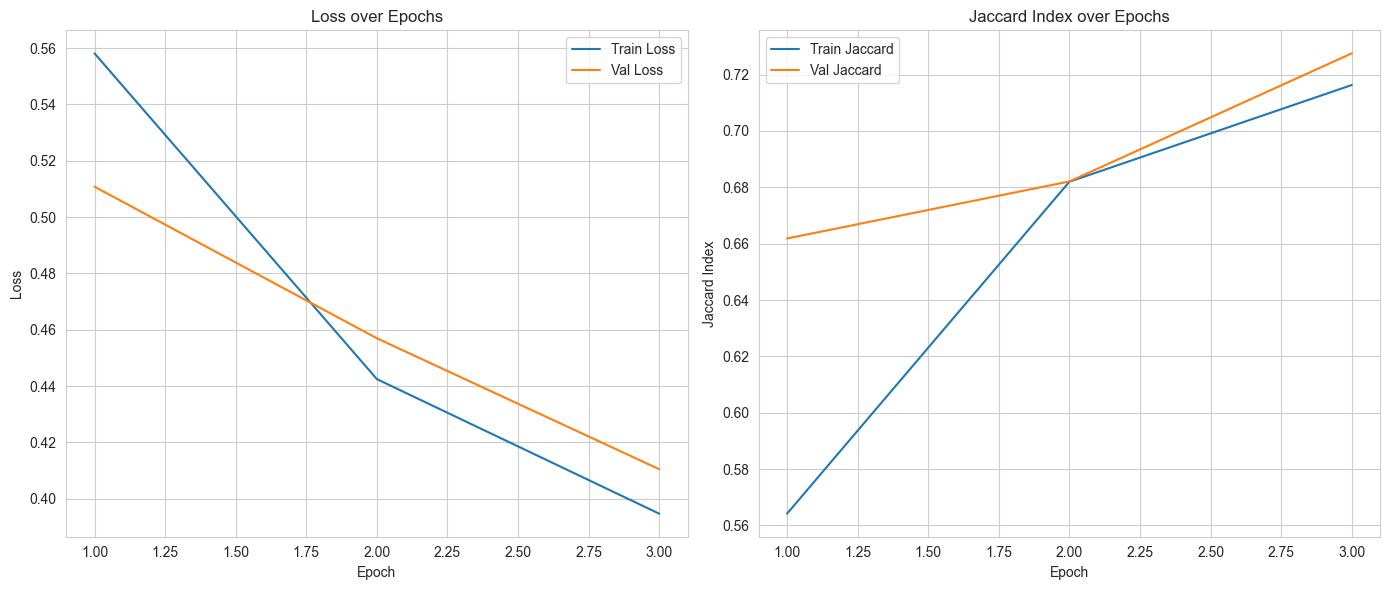

Evaluating Jaccard: 100%|██████████| 300/300 [00:10<00:00, 29.30it/s]


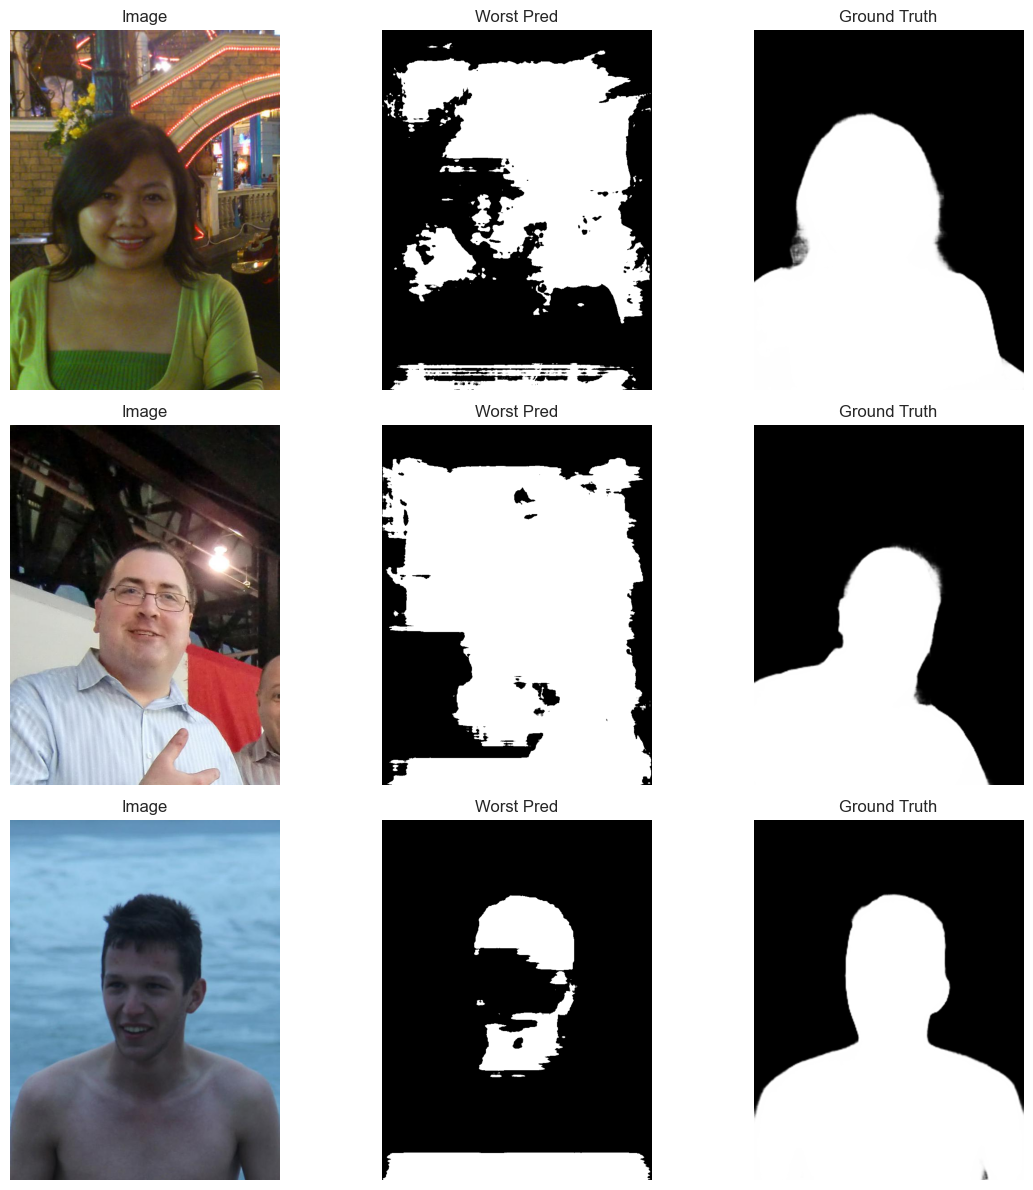


====== Fold 4 ======



Epoch 1/3 - Training: 100%|██████████| 340/340 [03:31<00:00,  1.61it/s]


[Epoch 1] Train Loss: 0.5922 | Train Jaccard: 0.5672


Epoch 1/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.44it/s]


[Epoch 1] Val Loss: 0.8073 | Val Jaccard: 0.5614


Epoch 2/3 - Training: 100%|██████████| 340/340 [03:33<00:00,  1.60it/s]


[Epoch 2] Train Loss: 0.4848 | Train Jaccard: 0.6501


Epoch 2/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.18it/s]


[Epoch 2] Val Loss: 0.4250 | Val Jaccard: 0.6961


Epoch 3/3 - Training: 100%|██████████| 340/340 [03:30<00:00,  1.62it/s]


[Epoch 3] Train Loss: 0.4029 | Train Jaccard: 0.7140


Epoch 3/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.41it/s]


[Epoch 3] Val Loss: 0.3972 | Val Jaccard: 0.7372


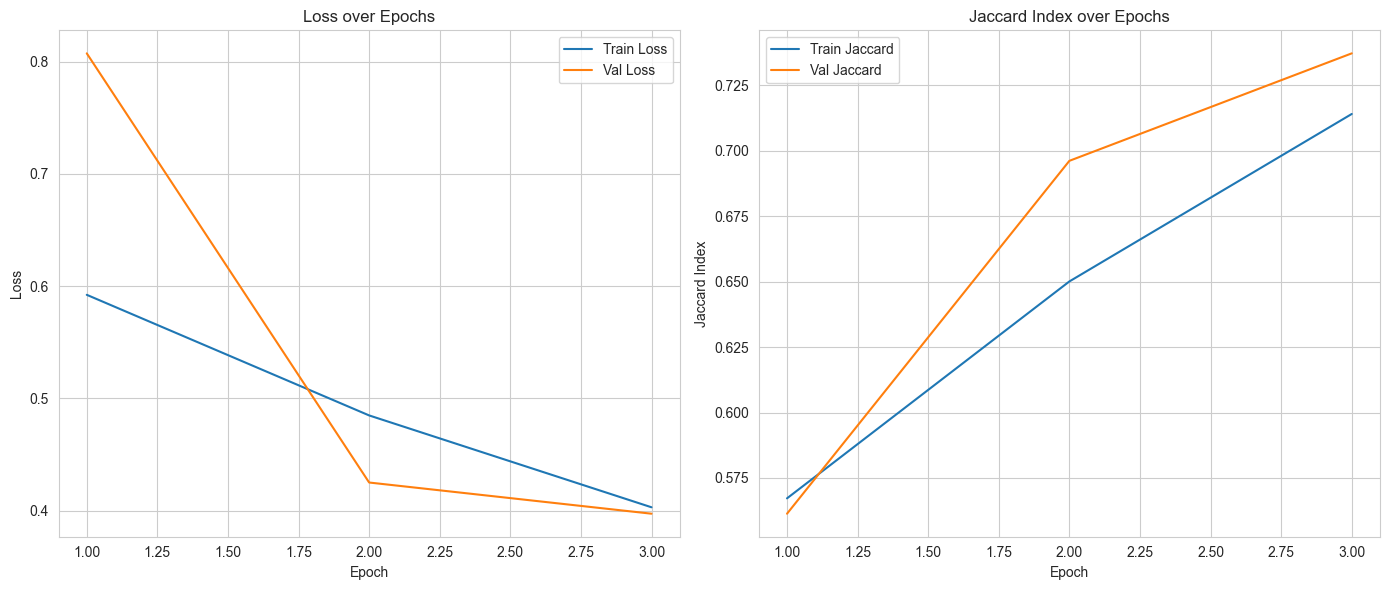

Evaluating Jaccard: 100%|██████████| 300/300 [00:11<00:00, 27.09it/s]


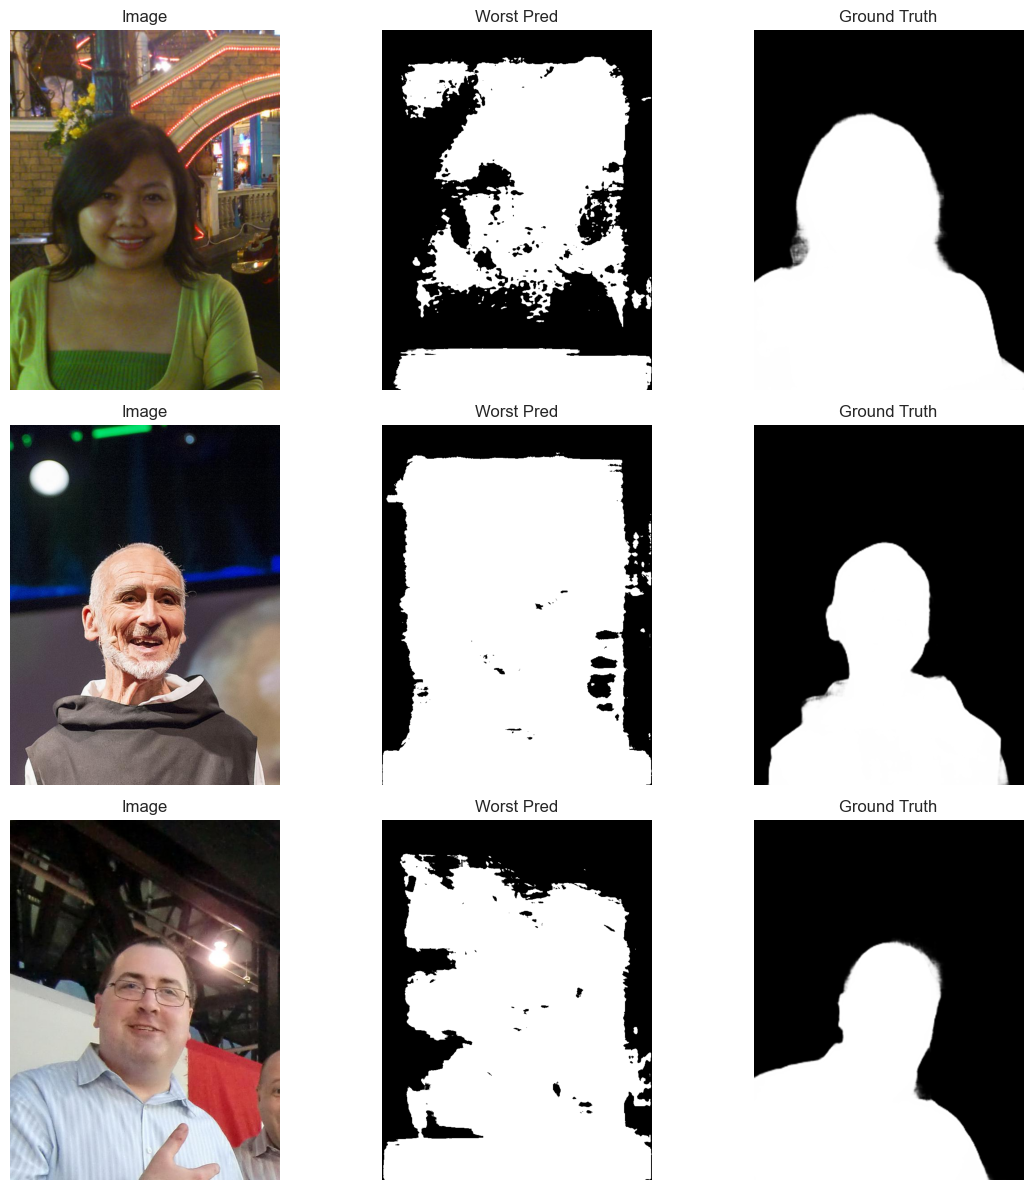


====== Fold 5 ======



Epoch 1/3 - Training: 100%|██████████| 340/340 [03:38<00:00,  1.56it/s]


[Epoch 1] Train Loss: 0.5693 | Train Jaccard: 0.5593


Epoch 1/3 - Validation: 100%|██████████| 85/85 [00:09<00:00,  8.74it/s]


[Epoch 1] Val Loss: 0.6110 | Val Jaccard: 0.4312


Epoch 2/3 - Training: 100%|██████████| 340/340 [03:35<00:00,  1.58it/s]


[Epoch 2] Train Loss: 0.5004 | Train Jaccard: 0.6446


Epoch 2/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.41it/s]


[Epoch 2] Val Loss: 0.5471 | Val Jaccard: 0.5649


Epoch 3/3 - Training: 100%|██████████| 340/340 [03:37<00:00,  1.57it/s]


[Epoch 3] Train Loss: 0.4638 | Train Jaccard: 0.6702


Epoch 3/3 - Validation: 100%|██████████| 85/85 [00:10<00:00,  8.50it/s]


[Epoch 3] Val Loss: 0.4591 | Val Jaccard: 0.6725


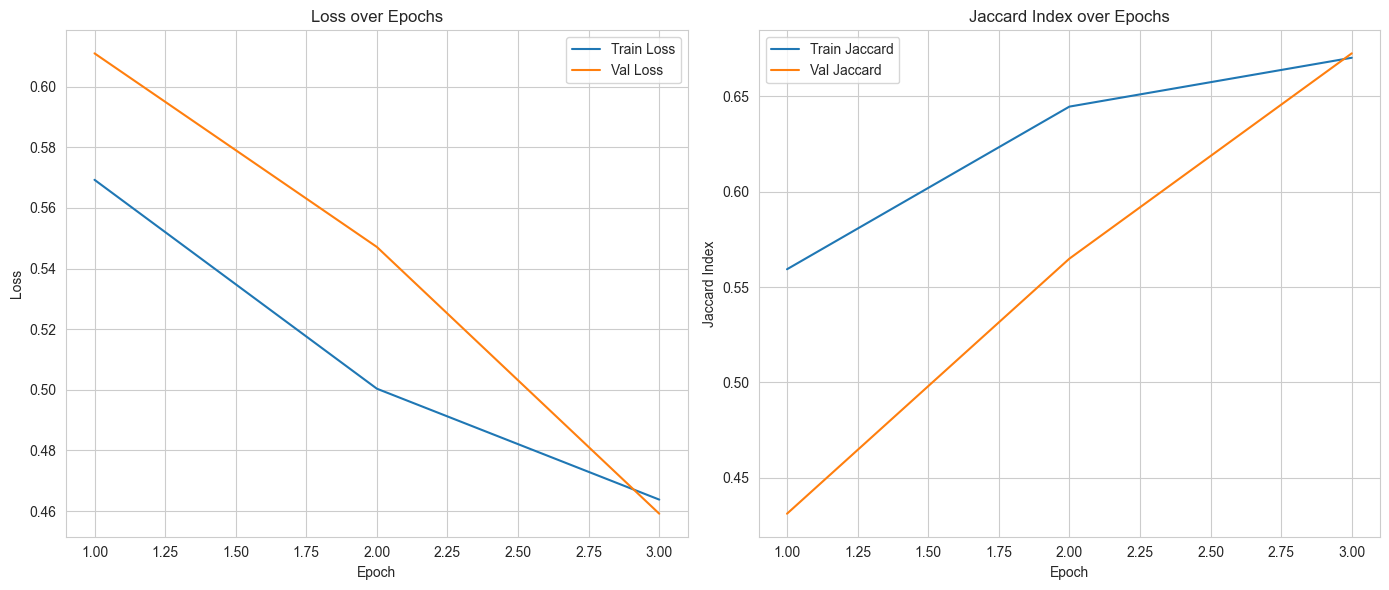

Evaluating Jaccard: 100%|██████████| 300/300 [00:10<00:00, 28.97it/s]


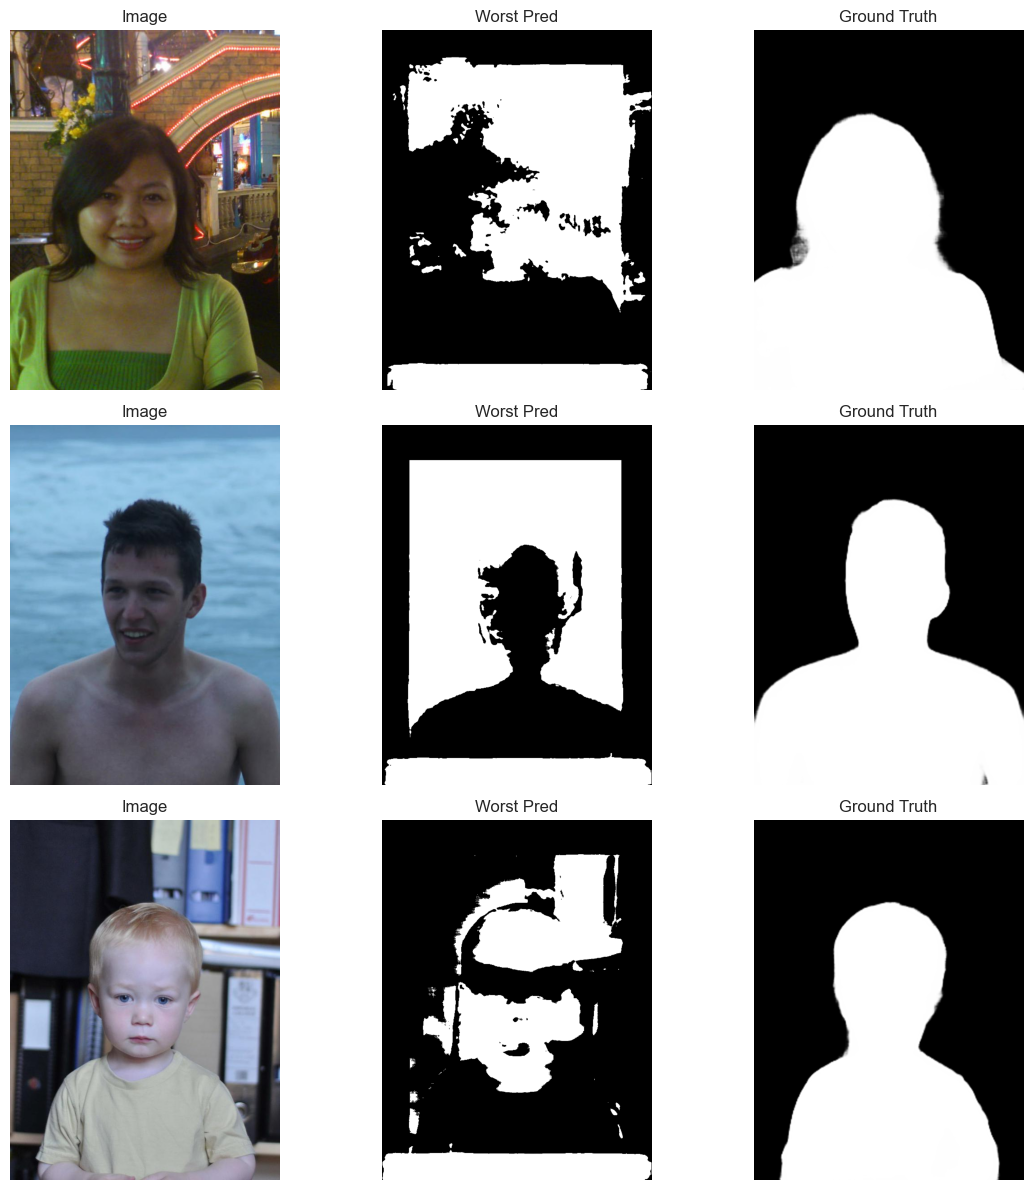

In [36]:
from sklearn.model_selection import KFold

image_paths = train_dataset.images
mask_paths = train_dataset.masks

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
folds = list(kfold.split(image_paths))

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"\n====== Fold {fold_idx + 1} ======\n")

    train_subset = SelfieDataset(
        [image_paths[i] for i in train_idx],
        [mask_paths[i] for i in train_idx],
        transform=train_dataset.transform
    )
    val_subset = SelfieDataset(
        [image_paths[i] for i in val_idx],
        [mask_paths[i] for i in val_idx],
        transform=train_dataset.transform
    )

    model = UNET(3, 16, 1)
    label = f"Fold_{fold_idx+1}"
    trained_model = train_and_validate(
        model, train_subset, val_subset, criterion, device=device,
        epochs=3, metrics_summary=metrics, label=label, batch_size=4
    )
    worst_ids = topN_worst(trained_model, test_dataset, device=device, top_n=3)
    triplets = get_predictions(trained_model, test_dataset, device=device, indices=worst_ids)
    plot_prediction_triplets(triplets, titles=("Image", "Worst Pred", "Ground Truth"))

Фолды показали себя хуже всех, оценивая по худшим результатам и графикам. Сравним метрики в табличном виде

## Сравнение всех результатов

In [37]:
compare_metrics_table(metrics)

Train Loss  Val Loss  Train Jaccard  Val Jaccard
overfitting    0.052521  0.159502       0.961990     0.894869
fitting        0.151178  0.173119       0.893851     0.875342
augmented      0.341866  0.212255       0.788371     0.866344
ResNet34       0.069370  0.061539       0.953562     0.957225
Fold_1         0.435156  0.424420       0.686814     0.704681
Fold_2         0.413149  0.467275       0.705942     0.694898
Fold_3         0.394725  0.410507       0.716313     0.727561
Fold_4         0.402947  0.397225       0.714011     0.737162
Fold_5         0.463787  0.459137       0.670203     0.672510

Подытожив можно сказать, что:

* Аугментация лишь ухудшила результаты
* Фолды справляются хуже всего с объектами с монолитным фоном, либо большими объектами. Да и в целом показали худшие результаты
* ResNet34 ощутимого прироста не дал
* Лучшая модель: ResNet34
* Худшая модель: 5Fold